In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from typing import TypedDict, Annotated, Literal, NotRequired

import uuid
import os
from dotenv import load_dotenv

load_dotenv()

True

## 日记模块

In [2]:
class DiaryState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def diary_agent(state: DiaryState) -> DiaryState:
    return {"messages": [AIMessage(content="日记模块已启动, 请开始记录")]}

DiaryModel = StateGraph(DiaryState)
DiaryModel.add_node("diary_agent", diary_agent)
DiaryModel.add_edge(START, "diary_agent")
DiaryModel.add_edge("diary_agent", END)

diary_graph = DiaryModel.compile()

## 冥想模块

In [3]:
class MeditationState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def meditation_agent(state: MeditationState) -> MeditationState:
    return {"messages": [AIMessage(content="冥想模块已启动, 请开始冥想")]}

MeditationModel = StateGraph(MeditationState)
MeditationModel.add_node("meditation_agent", meditation_agent)
MeditationModel.add_edge(START, "meditation_agent")
MeditationModel.add_edge("meditation_agent", END)

meditation_graph = MeditationModel.compile()


## 主对话模块

In [4]:
class RouterState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    route: Literal["diary", "meditation", "normal_chat"]

class Router(TypedDict):
    route: Literal["diary", "meditation", "normal_chat"]

with open('../prompts/chat_prompt.txt', 'r') as file:
    system_prompt = file.read().strip()

normal_system_prompt = ChatPromptTemplate([SystemMessage(content=system_prompt), MessagesPlaceholder(variable_name="messages")])

llm = ChatOpenAI(model="deepseek-chat", openai_api_key=os.getenv("DEEPSEEK_API_KEY"), openai_api_base='https://api.deepseek.com')
router_model = llm.with_structured_output(Router)
normal_llm = normal_system_prompt | llm

def router_node(state: RouterState):
    system_message = system_message = """你是一个智能路由分类器。你的职责是严格按照以下规则进行分类：

    基本原则：
    默认情况下应返回 "normal_chat"，只有在用户明确表示要在当下进行冥想或写日记时才改变路由。

    具体分类规则：
    1. 返回 "diary" 仅限于：
       - 用户明确说"我现在要写日记"、"开始写日记吧"等表示当下要写日记的话
       - 对 AI 的日记建议回复"好"、"可以"、"同意"等明确同意的话

    2. 返回 "meditation" 仅限于：
       - 用户明确说"我现在要冥想"、"让我们开始冥想吧"、"请生成一个 xxx 的冥想音频"等表示当下要冥想的话
       - 对 AI 的冥想建议回复"好"、"可以"、"同意"等明确同意的话

    3. 返回 "normal_chat" 的情况（包括但不限于）：
       - 用户在讨论冥想经验（如"冥想的时候总是走神"）
       - 用户在讨论过去的冥想体验（如"冥想音频已生成"）
       - 用户在询问冥想或日记相关建议
       - 用户表达负面情绪（如焦虑、压力等）
       - 用户对功能建议没有明确回应
       - 所有其他对话内容

    错误示例：
    - 用户说"冥想的时候总是走神" -> 应返回 normal_chat，而不是 meditation
    - 用户说"冥想音频已生成" -> 应返回 normal_chat，而不是 meditation
    - 用户说"上次写日记的感受很好" -> 应返回 normal_chat，而不是 diary
    - 用户说"我想学习冥想" -> 应返回 normal_chat，而不是 meditation

    关键判断：
    - 必须明确区分"讨论某个功能"和"要使用某个功能"
    - 只有用户明确表示要在当下使用功能时才转换路由
    - 如有任何疑虑，始终返回 normal_chat
    """
    messages = [SystemMessage(content=system_message)] + state["messages"]
    route = router_model.invoke(messages)
    return {"route": route["route"]}

def normal_chat_agent(state: RouterState):
    response = normal_llm.invoke(state["messages"])
    return {"messages": [response]}

def diary_agent(state: RouterState):
    response = diary_graph.invoke(state)
    return {"messages": [response["messages"][-1]]}

def meditation_agent(state: RouterState):
    response = meditation_graph.invoke(state)
    return {"messages": [response["messages"][-1]]}

def condition_edge(state: RouterState):
    if state["route"] == "diary":
        return "diary_agent"
    elif state["route"] == "meditation":
        return "meditation_agent"
    else:
        return "normal_chat_agent"

MainDialogueModel = StateGraph(RouterState)
MainDialogueModel.add_node("router_node", router_node)
MainDialogueModel.add_node("normal_chat_agent", normal_chat_agent)
MainDialogueModel.add_node("diary_agent", diary_agent)
MainDialogueModel.add_node("meditation_agent", meditation_agent)
MainDialogueModel.add_edge(START, "router_node")
MainDialogueModel.add_conditional_edges("router_node", condition_edge)
MainDialogueModel.add_edge("normal_chat_agent", END)
MainDialogueModel.add_edge("diary_agent", END)
MainDialogueModel.add_edge("meditation_agent", END)

memory = MemorySaver()
main_dialogue_graph = MainDialogueModel.compile(checkpointer=memory, interrupt_before=["diary_agent", "meditation_agent"])

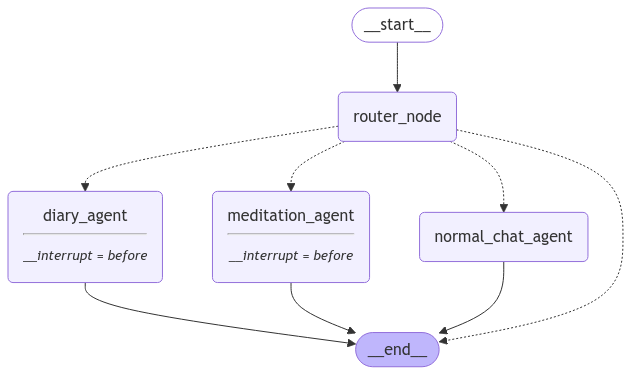

In [5]:
main_dialogue_graph

In [6]:
config = {"configurable": {"thread_id": "001"}}

In [7]:
inputs = {"messages": [HumanMessage(content="请为我生成一段有助睡眠的冥想脚本")]}
for chunk in main_dialogue_graph.stream(inputs, config=config, stream_mode="values"):
    # print(chunk[0].content,  end="")
    chunk['messages'][-1].pretty_print()
state = main_dialogue_graph.get_state(config)
if state.next:
    if state.next[0] == "diary_agent":
        user_approval = input("是否打开显化日记本？(yes/no):")
        if user_approval.lower() == "yes":
            for chunk in main_dialogue_graph.stream(None, config=config, stream_mode="messages"):
                print(chunk[0].content,  end="")
    elif state.next[0] == "meditation_agent":
        user_approval = input("是否打开冥想音频？(yes/no):")
        if user_approval.lower() == "yes":
            for chunk in main_dialogue_graph.stream(None, config=config, stream_mode="messages"):
                print(chunk[0].content,  end="")


================================ Human Message =================================

请为我生成一段有助睡眠的冥想脚本
================================ Human Message =================================

请为我生成一段有助睡眠的冥想脚本
================================== Ai Message ==================================

当然，我很乐意为你创作一段助眠冥想脚本。让我们一起来创造一个宁静的夜晚体验吧。🌙

---

**宁静之夜：助眠冥想脚本**

亲爱的朋友，请找一个舒适的地方躺下或坐下，闭上眼睛，开始我们的宁静之旅。

1. **深呼吸**  
   首先，深深地吸一口气，感受空气缓缓进入你的鼻腔，充满你的肺部。然后，慢慢地呼出，感受所有的紧张和压力随着呼气离开你的身体。再来一次，深深地吸气，慢慢地呼气。让每一次呼吸都带你进入更深层的放松状态。

2. **身体扫描**  
   现在，让我们从脚趾开始，慢慢地扫描你的身体。感受你的脚趾，它们是否感到沉重或轻松？让它们完全放松。接着是你的脚踝、小腿、膝盖，让每一块肌肉都放松下来。继续向上，感受你的大腿、臀部、腹部，让它们都沉浸在舒适和放松中。然后是胸部、肩膀、手臂，直到你的指尖。最后，感受你的脖子、脸部，让所有的紧张都消失。

3. **想象宁静的场景**  
   现在，想象你正躺在一片柔软的草地上，周围是宁静的夜晚。你可以听到微风轻轻拂过树叶的声音，感受到草地上的露珠轻轻触碰你的皮肤。抬头看，夜空中繁星点点，月亮温柔地照耀着你。感受这份宁静和安详，让它们充满你的整个身体。

4. **肯定宣言**  
   在心里默念这些肯定宣言：  
   - 我允许自己完全放松。  
   - 我感受到宁静和安详。  
   - 我信任我的身体，它会带我进入深沉的睡眠。  
   - 我值得拥有一个美好的夜晚和充足的休息。

5. **回归呼吸**  
   最后，再次将注意力回到你的呼吸上。感受每一次吸气和呼气，让它们带你进入更深层的放松状态。当你准备好时，慢慢地睁开眼睛，带着这份宁静和安